# LSTM_Approach :

### Split the signal into train and test set. Predict the test set using the model trained with train set. Compare between the test set and predicted set using the fixed window_size using either MSE or RMSE. Pick the top 5 signals with largest MSE or RMSE values which are the abnormal signals.

# Libraries to be imported

In [154]:
import numpy as np
import tensorflow as tf

pd.options.mode.chained_assignment=None
import seaborn as sns
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import os

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize']=14,8
np.random.seed(1)
tf.random.set_seed(1)
print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

2.3.0


In [155]:
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith('.dat')]

In [156]:
records={}
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith(".dat")]   
for file in flist:
    records[file] = wfdb.rdrecord('../data/ECGdata/Person_90/'+file[:-4],channels=[1])

In [157]:
records

{'rec_2.dat': <wfdb.io.record.Record at 0x7fc602154b10>,
 'rec_1.dat': <wfdb.io.record.Record at 0x7fc5fce61c10>}

In [158]:
series={}
for rec in records:
    series[rec]=np.ndarray.flatten(records[rec].p_signal[:])

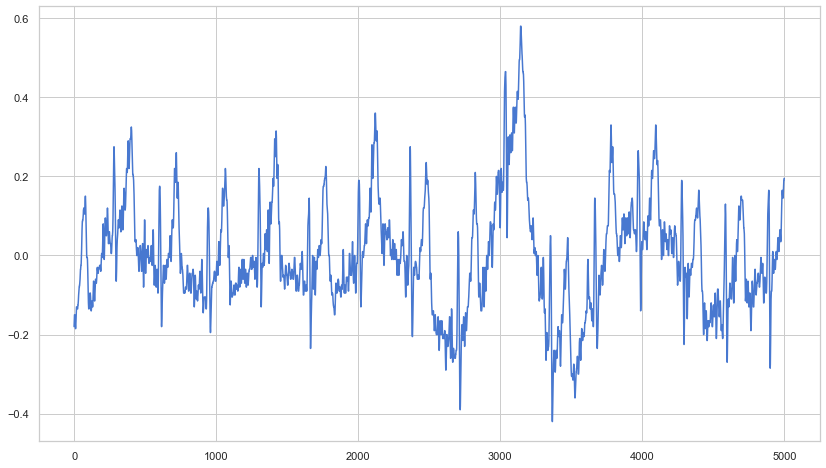

In [168]:
plt.plot(series['rec_1.dat'][5000:])

# Time series-Predict

In [160]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [161]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Dividing the data into train and test set

In [162]:
x_train={}
x_valid={}
split_time=5000
for rec in records:
    x_train[rec] = series[rec][:split_time]
    x_valid[rec] = series[rec][split_time:]

In [122]:
shuffle_buffer_size = 1000

In [99]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set={}
for rec in records:
    train_set[rec] = windowed_dataset(x_train[rec], window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history={}
for rec in records:
    history[rec] = model.fit(train_set[rec],epochs=500)

Epoch 1/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0210 - mae: 0.1233
Epoch 2/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0043 - mae: 0.0627
Epoch 3/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0038 - mae: 0.0576
Epoch 4/500
50/50 [==============================] - 2s 47ms/step - loss: 0.0036 - mae: 0.0560
Epoch 5/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0035 - mae: 0.0554
Epoch 6/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0034 - mae: 0.0543
Epoch 7/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0032 - mae: 0.0528
Epoch 8/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0029 - mae: 0.0504
Epoch 9/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0025 - mae: 0.0447
Epoch 10/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0022 - mae: 0.0424
Epoch 11/500
50/50 [=============================

50/50 [==============================] - 2s 47ms/step - loss: 7.7498e-04 - mae: 0.0277
Epoch 168/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5857e-04 - mae: 0.0272
Epoch 169/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5469e-04 - mae: 0.0271
Epoch 170/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5188e-04 - mae: 0.0271
Epoch 171/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5447e-04 - mae: 0.0272
Epoch 172/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5832e-04 - mae: 0.0273
Epoch 173/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5888e-04 - mae: 0.0274
Epoch 174/500
50/50 [==============================] - 2s 47ms/step - loss: 7.6411e-04 - mae: 0.0276
Epoch 175/500
50/50 [==============================] - 2s 47ms/step - loss: 7.4834e-04 - mae: 0.0271
Epoch 176/500
50/50 [==============================] - 2s 47ms/step - loss: 7.6389e-04 - mae: 0.0276
Epoc

50/50 [==============================] - 2s 47ms/step - loss: 6.0557e-04 - mae: 0.0248
Epoch 330/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0268e-04 - mae: 0.0247
Epoch 331/500
50/50 [==============================] - 2s 47ms/step - loss: 6.1505e-04 - mae: 0.0251
Epoch 332/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0154e-04 - mae: 0.0247
Epoch 333/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9967e-04 - mae: 0.0246
Epoch 334/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9814e-04 - mae: 0.0246
Epoch 335/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0227e-04 - mae: 0.0247
Epoch 336/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0262e-04 - mae: 0.0247
Epoch 337/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9915e-04 - mae: 0.0246
Epoch 338/500
50/50 [==============================] - 2s 48ms/step - loss: 5.9538e-04 - mae: 0.0245
Epoc

50/50 [==============================] - 3s 59ms/step - loss: 5.2041e-04 - mae: 0.0230
Epoch 492/500
50/50 [==============================] - 3s 60ms/step - loss: 5.2140e-04 - mae: 0.0231
Epoch 493/500
50/50 [==============================] - 3s 58ms/step - loss: 5.2141e-04 - mae: 0.0231
Epoch 494/500
50/50 [==============================] - 2s 48ms/step - loss: 5.1875e-04 - mae: 0.0230
Epoch 495/500
50/50 [==============================] - 3s 63ms/step - loss: 5.1950e-04 - mae: 0.0230
Epoch 496/500
50/50 [==============================] - 3s 51ms/step - loss: 5.2219e-04 - mae: 0.0231
Epoch 497/500
50/50 [==============================] - 3s 53ms/step - loss: 5.2574e-04 - mae: 0.0233
Epoch 498/500
50/50 [==============================] - 2s 48ms/step - loss: 5.1604e-04 - mae: 0.0229
Epoch 499/500
50/50 [==============================] - 3s 53ms/step - loss: 5.2535e-04 - mae: 0.0233
Epoch 500/500
50/50 [==============================] - 2s 50ms/step - loss: 5.1574e-04 - mae: 0.0229
Epoc

50/50 [==============================] - 3s 50ms/step - loss: 7.0298e-04 - mae: 0.0270
Epoch 155/500
50/50 [==============================] - 3s 61ms/step - loss: 6.8886e-04 - mae: 0.0266
Epoch 156/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8841e-04 - mae: 0.0266
Epoch 157/500
50/50 [==============================] - 2s 50ms/step - loss: 6.9511e-04 - mae: 0.0268
Epoch 158/500
50/50 [==============================] - 3s 53ms/step - loss: 6.8717e-04 - mae: 0.0266
Epoch 159/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8554e-04 - mae: 0.0265
Epoch 160/500
50/50 [==============================] - 3s 54ms/step - loss: 6.8563e-04 - mae: 0.0266
Epoch 161/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8973e-04 - mae: 0.0267
Epoch 162/500
50/50 [==============================] - 3s 54ms/step - loss: 6.8764e-04 - mae: 0.0266
Epoch 163/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8539e-04 - mae: 0.0266
Epoc

50/50 [==============================] - 3s 53ms/step - loss: 6.1725e-04 - mae: 0.0254
Epoch 317/500
50/50 [==============================] - 3s 53ms/step - loss: 6.1722e-04 - mae: 0.0254
Epoch 318/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1915e-04 - mae: 0.0254
Epoch 319/500
50/50 [==============================] - 3s 55ms/step - loss: 6.1749e-04 - mae: 0.0254
Epoch 320/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1574e-04 - mae: 0.0254
Epoch 321/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2079e-04 - mae: 0.0255
Epoch 322/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2430e-04 - mae: 0.0256
Epoch 323/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1758e-04 - mae: 0.0255
Epoch 324/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2237e-04 - mae: 0.0256
Epoch 325/500
50/50 [==============================] - 3s 52ms/step - loss: 6.1570e-04 - mae: 0.0254
Epoc

50/50 [==============================] - 2s 49ms/step - loss: 5.7094e-04 - mae: 0.0246
Epoch 479/500
50/50 [==============================] - 2s 49ms/step - loss: 5.7130e-04 - mae: 0.0246
Epoch 480/500
50/50 [==============================] - 2s 49ms/step - loss: 5.7050e-04 - mae: 0.0246
Epoch 481/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7178e-04 - mae: 0.0246
Epoch 482/500
50/50 [==============================] - 2s 48ms/step - loss: 5.6787e-04 - mae: 0.0245
Epoch 483/500
50/50 [==============================] - 2s 48ms/step - loss: 5.6869e-04 - mae: 0.0245
Epoch 484/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7048e-04 - mae: 0.0246
Epoch 485/500
50/50 [==============================] - 2s 49ms/step - loss: 5.6941e-04 - mae: 0.0246
Epoch 486/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7250e-04 - mae: 0.0247
Epoch 487/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7007e-04 - mae: 0.0246
Epoc

In [116]:
rnn_forecast={}
for rec in records:
    rnn_forecast[rec] = model_forecast(model, series[rec][...,np.newaxis], window_size)
    rnn_forecast[rec] = rnn_forecast[rec][split_time-window_size:-1, -1, 0]

# Plot to check the actual data vs Predicted data

NameError: name 'rnn_forecast' is not defined

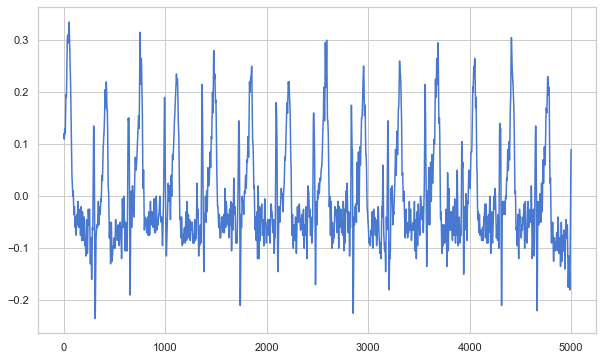

In [164]:
plt.figure(figsize=(10, 6))
for rec in records:
    plt.plot(x_valid[rec])
    plt.plot(rnn_forecast[rec][:])
    plt.show()

# Compare between Actual and Predicted signal using MSE Approach

In [303]:
def find_cmp_dd_detect(data,pred,win_size):
    p,q,cnt=0,0,1
    best_so_far=0
    cmp_=[]
    rm_=[]
    while win_size*cnt<len(data):
        sum1=0
        rmse_=0
        p=data[:win_size*cnt]
        q=pred[:win_size*cnt]
        for k in range(len(p)):
            m=len(p)
            sum1=sum1+((abs(p[k]-q[k]))**2)
            rmse_=(sum1)/m
            
        if rmse_ not in rm_:
            cmp_.append([rmse_,win_size*cnt])
            rm_.append(rmse_)
        cnt+=1
    return cmp_

In [304]:
cmp_discords={}
num_discords=5
win_size=200
cmp_max_discords={}
for rec in records: 
    cmp_discords[rec]=find_cmp_dd_detect(x_valid[rec],rnn_forecast[rec],win_size)

# Pick the top 5 discords

In [305]:
def max_cmp(cmp_,num_discords):
    maxi = []
    val = []
    rm_ = []
    for i in range(len(cmp_)):
        rm_.append(cmp_[i][0])
    for i in range(num_discords):
        best_so_far=None
        for j in rm_:
            if best_so_far == None:
                best_so_far = j
            elif best_so_far < j:
                best_so_far = j
        rm_.remove(best_so_far)
        maxi.append(best_so_far)
        for j in cmp_:
            if best_so_far == j[0]:
                val.append([j[0],j[1]])
    return val

In [306]:
cmp_max_dd={}
for rec in records:
    cmp_max_dd[rec] = max_cmp(cmp_discords[rec],num_discords)

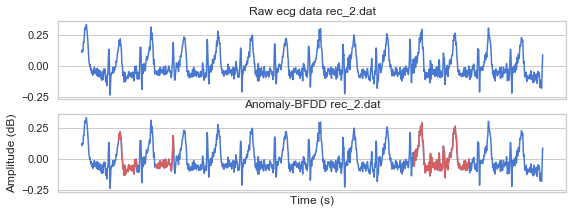

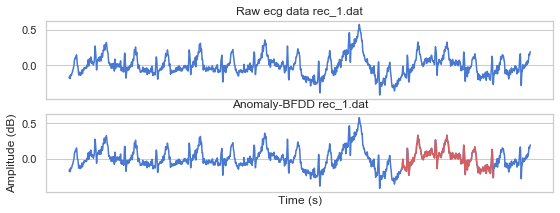

In [307]:
figsize = (20, 10)

ymin={}
ymax={}

for rec in records:
    plt.figure(figsize=figsize)

    plt.subplot2grid((6, 2), (0, 0))
    # plt.subplot(621)
    # plt.figure(1, figsize=left_figsize)
    # plt.clf()
    plt.xticks([])
    plt.plot(x_valid[rec])
    plt.title("Raw ecg data "+str(rec))
    plt.grid(True)
    
    ymin[rec] = np.min(x_valid[rec])
    ymax[rec] = np.max(x_valid[rec])
    alpha = 0.2 * (ymax[rec] - ymin[rec])
    ymax[rec] += alpha
    ymin[rec] -= alpha
    
    plt.subplot2grid((6, 2), (1, 0))
    plt.xticks([])
    # plt.clf()
    plt.ylabel("Amplitude (dB)")
    # Calculate time values in seconds
    times = np.arange(x_valid[rec].shape[0], dtype='float')
    plt.xlabel("Time (s)")
    plt.plot(x_valid[rec],color='b')
    for i in range(len(cmp_max_dd[rec])):
        indrpk1 = cmp_max_dd[rec][i][1]
#         plt.plot(np.concatenate((data[rec][:r_peaks[rec][int(max_dd[rec][i])+(map_sum[rec][0])]-1],data[rec][r_peaks[rec][int(max_dd[rec][i])]+1:r_peaks[rec][int(max_dd[rec][i])+1]]),axis=0),color='b')
        plt.plot(range(indrpk1+1,indrpk1+win_size+1),x_valid[rec][indrpk1+1:indrpk1+win_size+1],color='r')
    plt.title("Anomaly-BFDD "+str(rec))
    
    plt.grid(True)

# Labelled Data

In [110]:
from torch.utils.data import DataLoader

In [132]:
import torch
import tensorflow as tf

In [96]:
flist = os.listdir('../data/qtData/Data')
flist = [file for file in flist if file!='.DS_Store']

In [97]:
flist

['Abnormal', 'Normal']

In [98]:
data={} 
for file in flist:
    data[file] = os.listdir('../data/qtData/Data/'+file)
    data[file] = [fil for fil in data[file] if fil.endswith('.dat')]

In [99]:
records={}
for file in data:
    records[file]={}
    for rec in data[file]:
        records[file][rec] = wfdb.rdrecord('../data/qtData/Data/'+file+'/'+rec[:-4],channels=[1])

In [113]:
series={}
train_data={}
test_data={}
for file in records:
    series[file]={}
    train_data[file]={}
    test_data[file]={}
    for rec in records[file]:
        series[file][rec]=np.ndarray.flatten(records[file][rec].p_signal[:])
        train_data[file][rec]=series[file][rec][:int(len(series[file][rec])*0.8)]
        test_data[file][rec]=series[file][rec][int(len(series[file][rec])*0.8):]
        series[file][rec]=torch.from_numpy(series[file][rec])

In [148]:
# tf.ones(12)
train_labels={}
for file in records:
    train_labels[file]={}
    for rec in records[file]:
        if file=='Normal':
            train_labels[file][rec]=tf.ones(1)
        else:
            train_labels[file][rec]=tf.zeros(1)

In [150]:
# traindir = '../data/qtData/Data/'
# training_set = train_datagen.flow_from_directory(traindir,
#                                                  target_size=(224, 224),
#                                                  batch_size=batch_size,
#                                                  class_mode='categorical')

# # valid_set = valid_datagen.flow_from_directory(validdir,
# #                                             target_size=(224, 224),
# #                                             batch_size=batch_size,
# #                                             class_mode='categorical')

In [151]:
# traindir = "/content/drive/My Drive/plant_disease_dataset/train_valid/train"
# validdir = "/content/drive/My Drive/plant_disease_dataset/train_valid/valid"
# testdir = "/content/drive/My Drive/plant_disease_dataset/test/test"

# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    fill_mode='nearest')

# valid_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 128
# training_set = train_datagen.flow_from_directory(traindir,
#                                                  target_size=(224, 224),
#                                                  batch_size=batch_size,
#                                                  class_mode='categorical')

# valid_set = valid_datagen.flow_from_directory(validdir,
#                                             target_size=(224, 224),
#                                             batch_size=batch_size,
#                                             class_mode='categorical')

In [152]:
# train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
# valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
# test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)